In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ewtpy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from numpy import split
from numpy import array
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
import tensorflow as tf
import os
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

In [2]:
# Assuming `data` is your DataFrame
energy_data = pd.read_csv('energy_dataset.csv', parse_dates = ['time'])
energy_data.time = pd.to_datetime(energy_data.time, utc = True, infer_datetime_format= True)
data = energy_data.set_index('time')
columns_to_keep = ['price actual', 'generation solar', 'generation wind onshore', 'total load actual']

# Create a subset of the DataFrame
data = data[columns_to_keep]
data = data['2016-01-01':'2018-12-30']
data = data.interpolate(method='linear', axis=0)

In [3]:
def train_va_model(X_train):
    # Train the VAR model
    model = VAR(X_train)
    model = model.fit()
    
    return model

In [4]:
def create_lagged_variables(data, num_lags):
    """
    Create lagged features for each feature in the original array.

    Parameters:
    - original_array: 2D NumPy array with rows as observations and columns as features.
    - num_lags: Number of lagged values to create for each feature.

    Returns:
    - A new 2D NumPy array containing only the lagged features for each original variable.
    """
    original_array = np.array(data)
    # Initialize an empty list to store the lagged features
    lagged_features = []
    print(original_array.shape)
    # Number of features
    num_features = original_array.shape[1]

    # Create lagged features for each original feature
    for i in range(num_features):
        feature = original_array[:, i]
        for lag in range(1, num_lags + 1):
            # Create the lagged version of the feature
            lagged_feature = np.roll(feature, lag)
            # For the first 'lag' elements that are now invalid, set them to NaN
            lagged_feature[:lag] = np.nan
            # Append the lagged feature to the list
            lagged_features.append(lagged_feature)

    # Convert the list of lagged features into a NumPy array
    lagged_array = np.column_stack(lagged_features)

    return lagged_array

  # This should show the shape as expected, excluding original features.



In [6]:
def normalize_data(data, scaler_X, scaler_Y):
    df_final=data
    X = df_final[df_final.columns.drop('price actual')].values
    y = df_final['price actual'].values

    y = y.reshape(-1, 1)
    
    scaler_X.fit(X)
    scaler_Y.fit(y)
    
    X_norm = scaler_X.transform(X)
    y_norm = scaler_Y.transform(y)

    return X_norm, y_norm, scaler_Y

# Now, when preparing your sequences, use `scaled_features` for X and `scaled_target` for y


In [10]:
def split_train(dataset_norm):
    dt_train, dt_test= dataset_norm[0:round(0.75*len(dataset_norm))] ,  dataset_norm[round(0.75*len(dataset_norm)):]  
    return dt_train, dt_test


In [36]:


dt_train, dt_test = split_train(data)
dt_train_lag = create_lagged_variables(dt_train, 72)
dt_test_lag = create_lagged_variables(dt_test, 72)

(19710, 4)
(6570, 4)


Test RMSE: 3034.082, Test MAE: 2062.283


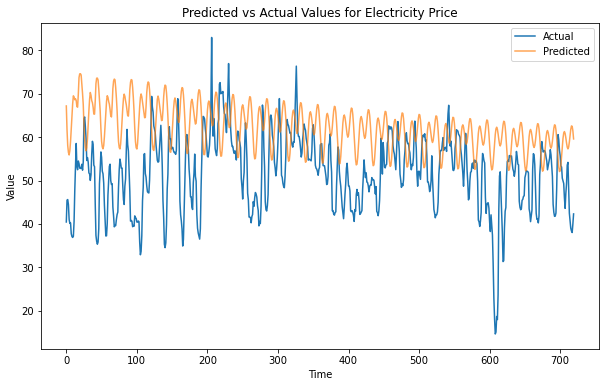

(6498, 288)


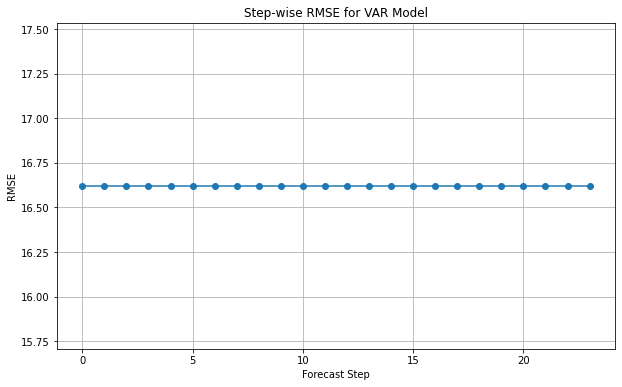

NameError: name 'model_name' is not defined

In [42]:
import math
dt_train_lag = dt_train_lag[~np.isnan(dt_train_lag).any(axis=1)]
dt_test_lag = dt_test_lag[~np.isnan(dt_test_lag).any(axis=1)]

va_model = train_va_model(dt_train_lag)
performance = evaluate_var_model(va_model, dt_test_lag)

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def evaluate_var_model(model_fitted, test_data, steps_ahead=1):
    """
    Evaluates the VAR model's performance on the test dataset and plots predictions against actual values.

    Parameters:
    - model_fitted: The fitted VAR model object.
    - test_data: The test dataset containing all variables.
    - model_name: Name of the model for display purposes.
    - steps_ahead: Number of steps ahead to evaluate the RMSE for hourly comparison (default: 24).
    
    Returns:
    - A tuple containing the model name, overall RMSE, and MAE.
    """
    # Forecasting
    lag_order = model_fitted.k_ar
    forecasted_values = model_fitted.forecast(test_data[-lag_order:], steps=len(test_data))

    # Calculate errors for each variable and overall
    overall_mae = mean_absolute_error(test_data, forecasted_values, multioutput='uniform_average')
    overall_rmse = math.sqrt(mean_squared_error(test_data, forecasted_values, multioutput='uniform_average'))

    print(f'Test RMSE: {overall_rmse:.3f}, Test MAE: {overall_mae:.3f}')
    
    # Plotting predicted vs actual values for the first variable as an example
    plt.figure(figsize=(10, 6))
    actual = test_data[0:720, 0]  # Assuming you want to plot the first variable
    predicted = forecasted_values[0:720, 0]
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted', alpha=0.7)
    plt.title(f'Predicted vs Actual Values for Electricity Price')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    print(test_data.shape)
    # Calculate and plot RMSE for each forecast step up to `steps_ahead` if applicable
    hourly_rmse = [math.sqrt(mean_squared_error(test_data[:, 0], forecasted_values[:, 0])) for i in range(24)]

    plt.figure(figsize=(10, 6))
    plt.plot(hourly_rmse, marker='o', label='Step-wise RMSE')
    plt.title('Step-wise RMSE for VAR Model')
    plt.xlabel('Forecast Step')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

    return (model_name, overall_rmse, overall_mae)